In [1]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import itertools

import sampler
import datasets
from earlystopping import EarlyStopping

from sklearn.metrics import accuracy_score, recall_score
from torch.autograd  import  Function

# Acoustic Branch

Inputs for acoustic branch will be N x 40 where N [1,33]  
Time step: (2, 10) (seconds?)  
N: relative duration after feature extraction

In [2]:
class AcousticNet(nn.Module):
    def __init__(self, num_conv_layers = 3, kernel_size = 2, conv_width = 32, num_gru_layers = 2):
        super(AcousticNet, self).__init__()
        self.num_conv_layers = num_conv_layers
        self.conv1 = nn.Conv1d(in_channels=40, out_channels=conv_width, kernel_size=kernel_size, padding = kernel_size - 1)
        self.conv2 = nn.Conv1d(in_channels=conv_width, out_channels=conv_width, kernel_size=kernel_size, padding = kernel_size - 1)
        self.conv3 = nn.Conv1d(in_channels=conv_width, out_channels=conv_width, kernel_size=kernel_size, padding = kernel_size - 1)
        self.conv4 = nn.Conv1d(in_channels=conv_width, out_channels=conv_width, kernel_size=kernel_size, padding = kernel_size - 1)
        self.convs = [self.conv1, self.conv2, self.conv3, self.conv4]
        self.max_pool = nn.MaxPool1d(kernel_size = 2)
        self.relu = nn.ReLU()
        
        self.gru = nn.GRU(input_size=conv_width,hidden_size=32,num_layers=num_gru_layers) # 19 is hardcoded
        self.mean_pool = nn.AvgPool1d(kernel_size=2)
        
    def forward(self, x):
        x = torch.transpose(x, 1, 2) 
#         print(x.shape)
        for i in range(self.num_conv_layers):
            x = self.relu(self.max_pool(self.convs[i](x)))
        x = torch.transpose(x, 1, 2) 
        x, _ = self.gru(x)
        x = torch.transpose(x, 1, 2)
        x = F.adaptive_avg_pool1d(x,1)[:, :, -1]
#         x = self.mean_pool(x)
        return x

In [3]:
# Test dummy input
net = AcousticNet(num_conv_layers = 3, kernel_size = 2, conv_width = 32, num_gru_layers = 2)
batch_size = 8
n_acoustic_channels = 40
duration_acoustic = 1232
test_vec = torch.randn(batch_size, duration_acoustic, n_acoustic_channels) # samples x features (or channels) x N (relative duration)
output = net(test_vec)
print(f'Shape of output: {output.shape}')
# assert output.shape[-1] == 16

Shape of output: torch.Size([8, 32])


# Lexical Branch

In [4]:
# implement GRU (or transformer)
class LexicalNet(nn.Module):
    def __init__(self, num_gru_layers = 2):
        super(LexicalNet, self).__init__()
        # implement GRU (or transformer)
        self.gru = nn.GRU(input_size=768,hidden_size=32,num_layers=num_gru_layers)
        self.mean_pool = nn.AvgPool1d(kernel_size=2) 
        self.flatten = nn.Flatten()
        
    def forward(self, x):
        x, _ = self.gru(x)
#         x = self.mean_pool(x)
        x = self.flatten(x)
#         print(x.shape)
        return x

In [5]:
# Test dummy input
net = LexicalNet(num_gru_layers = 2)
batch_size = 8
test_vec = torch.randn(batch_size, 1, 768)
output = net(test_vec)
# assert output.shape[-1] == 16

# Master branch

In [6]:
# class GRL(Function):
#     @staticmethod
#     def forward(self,x):
#         return x
#     @staticmethod
#     def backward(self,grad_output):
#         grad_input = grad_output.neg()
#         return grad_input

In [7]:
class GradientReversalFunction(Function):
    """
    Gradient Reversal Layer from:
    Unsupervised Domain Adaptation by Backpropagation (Ganin & Lempitsky, 2015)
    Forward pass is the identity function. In the backward pass,
    the upstream gradients are multiplied by -lambda (i.e. gradient is reversed)
    """

    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x.clone()

    @staticmethod
    def backward(ctx, grads):
        lambda_ = ctx.lambda_
        lambda_ = grads.new_tensor(lambda_)
        dx = -lambda_ * grads
        return dx, None
    
class GradientReversal(torch.nn.Module):
    def __init__(self, lambda_=1):
        super(GradientReversal, self).__init__()
        self.lambda_ = lambda_

    def forward(self, x):
        return GradientReversalFunction.apply(x, self.lambda_)

In [8]:
class MasterNet(nn.Module):
    def __init__(self, acoustic_modality = True, lexical_modality = True, visual_modality = False,
                 num_conv_layers = 3, kernel_size = 2, conv_width = 32, num_gru_layers = 2,
                 num_dense_layers = 1, dense_layer_width = 32, grl_lambda = .3):
        super(MasterNet, self).__init__()
        
        self.acoustic_modality = acoustic_modality
        self.lexical_modality = lexical_modality
        self.visual_modality = visual_modality
        
        self.acoustic_model = AcousticNet(num_conv_layers = num_conv_layers, kernel_size = kernel_size, 
                                     conv_width = conv_width, num_gru_layers = num_gru_layers)
        self.lexical_model = LexicalNet(num_gru_layers = 2)
        
        # emotion classifier
#         self.dense1_emo = nn.Linear()
#         self.dense2_emo = nn.Linear()
        
        width = 0 # width of the FC layers
        if self.acoustic_modality:
            width += 32
        if self.visual_modality:
            width += 0 # to implement
        if self.lexical_modality:
            width += 32
            
        self.fc_1 = nn.Linear(width, dense_layer_width)
        self.fc_2 = nn.Linear(dense_layer_width, 3)
        self.softmax = nn.Softmax(dim=1)

        self.relu = nn.ReLU()
#         # To implement   
#         if num_dense_layers == 2:
#             self.fc = nn.Sequential()
#             self.linear_1 = nn.Linear(width, dense_layer_width)
#         else:
#             self.fc = 
        
        # confound classifier -- to implement
        
        self.grl = GradientReversal(lambda_ = grl_lambda)
        self.dense_con = nn.Linear(width, 3)
#         self.dense2_con = None
        
        
    def forward_a(self, x_a):
        x = x_a
        x = self.acoustic_model(x)
        return x
    
    def forward_l(self, x_l):
        x = torch.unsqueeze(x_l, dim = 1)
        x = self.lexical_model(x)
        return x
    
    def forward_v(self, x_v):
        x = x_v
        return x
    
    def encoder(self, x_v, x_a, x_l):
#         print('x_a before encoding', x_a.shape)
#         print('x_l before encoding', x_l.shape)
        if self.visual_modality:
            x_v = self.forward_v(x_v)
        if self.acoustic_modality:
            x_a = self.forward_a(x_a)
        if self.lexical_modality:
            x_l = self.forward_l(x_l)
#         print('x_a after encoding', x_a.shape)
#         print('x_l after encoding', x_l.shape)
        
        if self.visual_modality:
            if self.acoustic_modality:
                if self.lexical_modality:
                    x = torch.cat((x_v, x_a, x_l), 1)
                else:
                    x = torch.cat((x_v, x_a), 1)
            else:
                if self.lexical_modality:
                    x = torch.cat((x_v, x_l), 1)
                else:
                    x = x_v
        else:
            if self.acoustic_modality:
                if self.lexical_modality:
                    x = torch.cat((x_a, x_l), 1)
                else:
                    x = x_a
            else:
                x = x_l
#         print('x after concat', x.shape)
        return x

    def stress_model(self, x):
#         x = self.grl.apply(x)
        x = self.grl(x)
        x = self.dense_con(x)
        x = self.softmax(x)
        return x
    
    def recognizer(self, x):
#         print(x.shape)
        x = self.relu(self.fc_1(x))
        x = self.fc_2(x)
        x = self.softmax(x)
        return x
    
    def forward(self, x_v, x_a, x_l):
        x = self.encoder(x_v, x_a, x_l)
        emotion_output = self.recognizer(x)
        stress_output = self.stress_model(x)
        
        return emotion_output, stress_output

In [9]:
# Test dummy input
net = MasterNet()
batch_size = 8
n_acoustic_channels = 40
duration_acoustic = 1232
acoustic_features = torch.randn(batch_size, duration_acoustic, n_acoustic_channels) # samples x features (or channels) x N (relative duration)
# lexical_features = torch.randn(batch_size, 1, 300)
lexical_features = torch.randn(batch_size, 768)
visual_features = None
emotion_output, stress_output = net(visual_features, acoustic_features, lexical_features)
print(f'Shape of emotion output: {emotion_output.shape}')
print(f'Shape of stress output: {stress_output.shape}')
print(emotion_output)
print(stress_output)
# assert output.shape[-1] == 16

Shape of emotion output: torch.Size([8, 3])
Shape of stress output: torch.Size([8, 3])
tensor([[0.3534, 0.3640, 0.2826],
        [0.3575, 0.3649, 0.2776],
        [0.3651, 0.3563, 0.2786],
        [0.3572, 0.3555, 0.2873],
        [0.3597, 0.3548, 0.2856],
        [0.3552, 0.3631, 0.2817],
        [0.3590, 0.3665, 0.2745],
        [0.3639, 0.3619, 0.2741]], grad_fn=<SoftmaxBackward>)
tensor([[0.3370, 0.3587, 0.3043],
        [0.3259, 0.3731, 0.3011],
        [0.3104, 0.3787, 0.3109],
        [0.3268, 0.3415, 0.3317],
        [0.3518, 0.3380, 0.3102],
        [0.3893, 0.3125, 0.2982],
        [0.3619, 0.3347, 0.3034],
        [0.3488, 0.3033, 0.3479]], grad_fn=<SoftmaxBackward>)


In [10]:
# Use specific GPU
def get_device():
    if torch.cuda.is_available():  
        dev = "cuda:0" 
    else:  
        dev = "cpu"  
    return torch.device(dev)
device = get_device()

In [21]:
def train_one_folder(model, folder = 0, epochs = 1, verbose = False, learning_rate = 1e-4, patience = 5):
    # Use specific GPU
    device = get_device()

    # Dataloaders    
    train_dataset_file_path = '../dataset/IEMOCAP/' + str(folder) + '/train.csv'
    train_loader = datasets.get_dataloader(train_dataset_file_path, 'train')
    test_dataset_file_path = '../dataset/IEMOCAP/' + str(folder) + '/test.csv'
    test_loader = datasets.get_dataloader(test_dataset_file_path, 'test')

    # Model, optimizer and loss function
    emotion_recognizer = model
    init_weights(emotion_recognizer)
    for param in emotion_recognizer.parameters():
        param.requires_grad = True
    emotion_recognizer.to(device)

    optimizer = torch.optim.Adam(emotion_recognizer.parameters(), lr=learning_rate)
    lr_schedule = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1)

    criterion = torch.nn.CrossEntropyLoss()

    best_acc = 0.
    best_uar = 0.
    es = EarlyStopping(patience=patience)

    # Train and validate
    for epoch in range(epochs):
        if verbose:
            print('epoch: {}/{}'.format(epoch + 1, epochs))

        train_loss, train_acc = train(train_loader, emotion_recognizer,
                                        optimizer, criterion, device)
        test_loss, test_acc, test_uar = test(test_loader, emotion_recognizer,
                                                criterion, device)

        if verbose:
            print('train_loss: {0:.5f}'.format(train_loss),
                    'train_acc: {0:.3f}'.format(train_acc),
                    'test_loss: {0:.5f}'.format(test_loss),
                    'test_acc: {0:.3f}'.format(test_acc),
                    'test_uar: {0:.3f}'.format(test_uar))

        lr_schedule.step(test_loss)

#         os.makedirs(os.path.join(opt.logger_path, opt.source_domain), exist_ok=True)

#         model_file_name = os.path.join(opt.logger_path, opt.source_domain, 'checkpoint.pth.tar')
#         state = {'epoch': epoch+1, 'emotion_recognizer': emotion_recognizer.state_dict(), 'opt': opt}
#         torch.save(state, model_file_name)

        if test_acc > best_acc:
#             model_file_name = os.path.join(opt.logger_path, opt.source_domain, 'model.pth.tar')
#             torch.save(state, model_file_name)

            best_acc = test_acc

        if test_uar > best_uar:
            best_uar = test_uar

        if es.step(test_loss):
            break

    return best_acc, best_uar

In [12]:
def train(train_loader, model, optimizer, criterion, device, verbose = False):
    model.train()

    running_loss = 0.
    running_acc = 0.

    groundtruth = []
    prediction = []

    for i, train_data in enumerate(train_loader):
        visual_features, _, acoustic_features, _, lexical_features, _, _, a_labels, _, _ = train_data # UPDATE

        visual_features = visual_features.to(device)
        acoustic_features = acoustic_features.to(device)
        lexical_features = lexical_features.to(device)

        labels = a_labels.to(device)

        optimizer.zero_grad()
        
        emotion_output, stress_output = model(visual_features, acoustic_features, lexical_features)

        emotion_loss = criterion(emotion_output, labels)
#         stress_loss = criterion(stress_output, stress_labels)

        emotion_loss.backward()
#         stress_loss.backward()
        
        optimizer.step() # do we need two optimizers?
        
        running_loss += emotion_loss.item()

        groundtruth.append(labels.tolist())
        predictions = emotion_output.argmax(dim=1, keepdim=True)
        prediction.append(predictions.view_as(labels).tolist())

        if verbose and i > 0 and int(len(train_loader) / 10) > 0 and i % (int(len(train_loader) / 10)) == 0:
            print('.', flush=True, end='')
            
    train_loss = running_loss / len(train_loader)

    groundtruth = list(itertools.chain.from_iterable(groundtruth))
    prediction = list(itertools.chain.from_iterable(prediction))

    train_acc = accuracy_score(prediction, groundtruth)

    return train_loss, train_acc

In [13]:
def test(test_loader, model, criterion, device):
    model.eval()

    running_loss = 0.
    running_acc = 0.

    with torch.no_grad():
        groundtruth = []
        prediction = []

        for i, test_data in enumerate(test_loader):
            visual_features, _, acoustic_features, _, lexical_features, _, _, a_labels, _, _ = test_data # UPDATE

            visual_features = visual_features.to(device)
            acoustic_features = acoustic_features.to(device)
            lexical_features = lexical_features.to(device)

            labels = a_labels.to(device)

            emotion_predictions, _ = model(visual_features, acoustic_features, lexical_features)
            loss = criterion(emotion_predictions, labels)

            running_loss += loss.item()

            groundtruth.append(labels.tolist())
            emotion_predictions = emotion_predictions.argmax(dim=1, keepdim=True)
            prediction.append(emotion_predictions.view_as(labels).tolist())

        test_loss = running_loss / len(test_loader)

        groundtruth = list(itertools.chain.from_iterable(groundtruth))
        prediction = list(itertools.chain.from_iterable(prediction))

        test_acc = accuracy_score(prediction, groundtruth)
        test_uar = recall_score(prediction, groundtruth, average='macro')

        return test_loss, test_acc, test_uar

In [14]:
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)

In [16]:
# emotion_recognizer = net.Model(opt)
emotion_recognizer = MasterNet(acoustic_modality = True, lexical_modality = True, visual_modality = False)
init_weights(emotion_recognizer)
for param in emotion_recognizer.parameters():
    param.requires_grad = True
emotion_recognizer.to(device)

learning_rate = 1e-4
optimizer = torch.optim.Adam(emotion_recognizer.parameters(), lr=learning_rate)
lr_schedule = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1)
criterion = torch.nn.CrossEntropyLoss()

train_dataset_file_path = '../dataset/IEMOCAP/0/train.csv'
train_loader = datasets.get_dataloader(train_dataset_file_path, 'train')
test_dataset_file_path = '../dataset/IEMOCAP/0/test.csv'
test_loader = datasets.get_dataloader(test_dataset_file_path, 'test')

for epoch in range(1):
    train_loss, train_acc = train(train_loader, emotion_recognizer, optimizer, criterion, device)
    print(train_acc)

test_loss, test_acc, test_uar = test(test_loader, emotion_recognizer, criterion, device)
print(test_acc)

0.383698296836983
0.4925783397471138


In [17]:
print(train_acc,test_acc)

0.383698296836983 0.4925783397471138


In [27]:
acc = []
uar = []

In [28]:
model = MasterNet(acoustic_modality = True, lexical_modality = True, visual_modality = False)
best_acc, best_uar = train_one_folder(model, folder = 0, verbose = True, epochs = 10)
acc.append(best_acc)
uar.append(best_uar)

epoch: 1/10
train_loss: 1.09713 train_acc: 0.350 test_loss: 1.09258 test_acc: 0.385 test_uar: 0.497
epoch: 2/10
train_loss: 1.05485 train_acc: 0.480 test_loss: 0.99448 test_acc: 0.608 test_uar: 0.526
epoch: 3/10
train_loss: 1.00438 train_acc: 0.522 test_loss: 0.95767 test_acc: 0.616 test_uar: 0.583
epoch: 4/10
train_loss: 0.98472 train_acc: 0.543 test_loss: 0.95484 test_acc: 0.601 test_uar: 0.547
epoch: 5/10
train_loss: 0.97051 train_acc: 0.561 test_loss: 0.94535 test_acc: 0.607 test_uar: 0.555
epoch: 6/10
train_loss: 0.95275 train_acc: 0.583 test_loss: 0.94903 test_acc: 0.592 test_uar: 0.564
epoch: 7/10
train_loss: 0.94403 train_acc: 0.597 test_loss: 0.95594 test_acc: 0.574 test_uar: 0.567
epoch: 8/10
train_loss: 0.93429 train_acc: 0.607 test_loss: 0.95236 test_acc: 0.582 test_uar: 0.568
epoch: 9/10
train_loss: 0.93019 train_acc: 0.616 test_loss: 0.94957 test_acc: 0.579 test_uar: 0.557
epoch: 10/10
train_loss: 0.93084 train_acc: 0.613 test_loss: 0.94949 test_acc: 0.580 test_uar: 0.557

In [29]:
model = MasterNet(acoustic_modality = True, lexical_modality = True, visual_modality = False)
best_acc, best_uar = train_one_folder(model, folder = 1, verbose = True, epochs = 10)
acc.append(best_acc)
uar.append(best_uar)

epoch: 1/10
train_loss: 1.09677 train_acc: 0.360 test_loss: 1.07883 test_acc: 0.486 test_uar: 0.456
epoch: 2/10
train_loss: 1.05017 train_acc: 0.475 test_loss: 0.98161 test_acc: 0.574 test_uar: 0.516
epoch: 3/10
train_loss: 1.00571 train_acc: 0.515 test_loss: 0.96012 test_acc: 0.592 test_uar: 0.521
epoch: 4/10
train_loss: 0.98320 train_acc: 0.544 test_loss: 0.94661 test_acc: 0.584 test_uar: 0.499
epoch: 5/10
train_loss: 0.96794 train_acc: 0.565 test_loss: 0.94390 test_acc: 0.588 test_uar: 0.536
epoch: 6/10
train_loss: 0.95261 train_acc: 0.585 test_loss: 0.94285 test_acc: 0.580 test_uar: 0.540
epoch: 7/10
train_loss: 0.94285 train_acc: 0.596 test_loss: 0.95042 test_acc: 0.565 test_uar: 0.539
epoch: 8/10
train_loss: 0.93306 train_acc: 0.610 test_loss: 0.94771 test_acc: 0.578 test_uar: 0.553
epoch: 9/10
train_loss: 0.91846 train_acc: 0.629 test_loss: 0.95011 test_acc: 0.571 test_uar: 0.552
epoch: 10/10
train_loss: 0.93281 train_acc: 0.607 test_loss: 0.95069 test_acc: 0.564 test_uar: 0.542

In [30]:
model = MasterNet(acoustic_modality = True, lexical_modality = True, visual_modality = False)
best_acc, best_uar = train_one_folder(model, folder = 2, verbose = True, epochs = 10)
acc.append(best_acc)
uar.append(best_uar)

epoch: 1/10
train_loss: 1.09326 train_acc: 0.378 test_loss: 1.06696 test_acc: 0.494 test_uar: 0.463
epoch: 2/10
train_loss: 1.03375 train_acc: 0.503 test_loss: 0.99560 test_acc: 0.551 test_uar: 0.579
epoch: 3/10
train_loss: 1.00079 train_acc: 0.524 test_loss: 0.97370 test_acc: 0.562 test_uar: 0.498
epoch: 4/10
train_loss: 0.98162 train_acc: 0.547 test_loss: 0.96379 test_acc: 0.564 test_uar: 0.519
epoch: 5/10
train_loss: 0.97818 train_acc: 0.556 test_loss: 0.96088 test_acc: 0.567 test_uar: 0.535
epoch: 6/10
train_loss: 0.95843 train_acc: 0.571 test_loss: 0.96754 test_acc: 0.551 test_uar: 0.543
epoch: 7/10
train_loss: 0.93942 train_acc: 0.595 test_loss: 0.95876 test_acc: 0.556 test_uar: 0.541
epoch: 8/10
train_loss: 0.93177 train_acc: 0.610 test_loss: 0.95935 test_acc: 0.558 test_uar: 0.544
epoch: 9/10
train_loss: 0.92904 train_acc: 0.615 test_loss: 0.96391 test_acc: 0.548 test_uar: 0.546
epoch: 10/10
train_loss: 0.92017 train_acc: 0.624 test_loss: 0.96648 test_acc: 0.548 test_uar: 0.546

In [31]:
model = MasterNet(acoustic_modality = True, lexical_modality = True, visual_modality = False)
best_acc, best_uar = train_one_folder(model, folder = 3, verbose = True, epochs = 10)
acc.append(best_acc)
uar.append(best_uar)

epoch: 1/10
train_loss: 1.09577 train_acc: 0.349 test_loss: 1.06419 test_acc: 0.491 test_uar: 0.423
epoch: 2/10
train_loss: 1.03375 train_acc: 0.494 test_loss: 1.00374 test_acc: 0.530 test_uar: 0.468
epoch: 3/10
train_loss: 0.99176 train_acc: 0.529 test_loss: 0.98995 test_acc: 0.541 test_uar: 0.454
epoch: 4/10
train_loss: 0.97208 train_acc: 0.556 test_loss: 0.98615 test_acc: 0.529 test_uar: 0.495
epoch: 5/10
train_loss: 0.95899 train_acc: 0.574 test_loss: 0.98135 test_acc: 0.538 test_uar: 0.496
epoch: 6/10
train_loss: 0.94146 train_acc: 0.600 test_loss: 0.99087 test_acc: 0.518 test_uar: 0.494
epoch: 7/10
train_loss: 0.94314 train_acc: 0.593 test_loss: 0.97982 test_acc: 0.529 test_uar: 0.503
epoch: 8/10
train_loss: 0.92680 train_acc: 0.618 test_loss: 0.98756 test_acc: 0.522 test_uar: 0.487
epoch: 9/10
train_loss: 0.91297 train_acc: 0.633 test_loss: 0.98669 test_acc: 0.523 test_uar: 0.499
epoch: 10/10
train_loss: 0.90907 train_acc: 0.636 test_loss: 0.98580 test_acc: 0.528 test_uar: 0.505

In [32]:
model = MasterNet(acoustic_modality = True, lexical_modality = True, visual_modality = False)
best_acc, best_uar = train_one_folder(model, folder = 4, verbose = True, epochs = 10)
acc.append(best_acc)
uar.append(best_uar)

epoch: 1/10
train_loss: 1.09494 train_acc: 0.364 test_loss: 1.08246 test_acc: 0.482 test_uar: 0.486
epoch: 2/10
train_loss: 1.03453 train_acc: 0.500 test_loss: 1.00392 test_acc: 0.540 test_uar: 0.498
epoch: 3/10
train_loss: 0.99740 train_acc: 0.531 test_loss: 0.98673 test_acc: 0.541 test_uar: 0.470
epoch: 4/10
train_loss: 0.97844 train_acc: 0.548 test_loss: 0.98851 test_acc: 0.528 test_uar: 0.485
epoch: 5/10
train_loss: 0.96337 train_acc: 0.576 test_loss: 0.97785 test_acc: 0.534 test_uar: 0.494
epoch: 6/10
train_loss: 0.95083 train_acc: 0.585 test_loss: 0.98297 test_acc: 0.535 test_uar: 0.505
epoch: 7/10
train_loss: 0.94385 train_acc: 0.593 test_loss: 0.97981 test_acc: 0.530 test_uar: 0.505
epoch: 8/10
train_loss: 0.93303 train_acc: 0.609 test_loss: 0.97709 test_acc: 0.536 test_uar: 0.510
epoch: 9/10
train_loss: 0.92573 train_acc: 0.620 test_loss: 0.98014 test_acc: 0.526 test_uar: 0.504
epoch: 10/10
train_loss: 0.93425 train_acc: 0.607 test_loss: 0.97914 test_acc: 0.528 test_uar: 0.505

<BarContainer object of 5 artists>

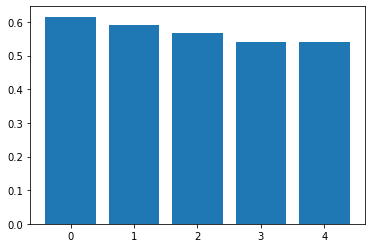

In [40]:
import matplotlib.pyplot as plt
plt.bar(range(5),acc)

<BarContainer object of 5 artists>

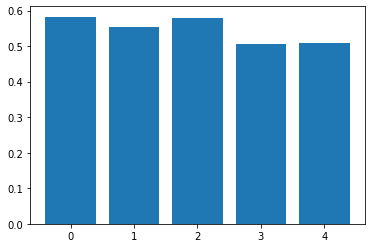

In [39]:
plt.bar(range(5),uar)

In [41]:
print(acc)
print(uar)

[0.6157229246838922, 0.5919381557150746, 0.5669475655430711, 0.5406562054208274, 0.5410138248847927]
[0.5826526522644119, 0.5532637338288996, 0.5787538872066461, 0.5047373306364468, 0.5097780299334587]


In [42]:
import pandas as pd

In [44]:
pd.DataFrame([acc,uar]).T

,0,1
0,0.615723,0.582653
1,0.591938,0.553264
2,0.566948,0.578754
3,0.540656,0.504737
4,0.541014,0.509778


In [45]:
np.average(acc)

0.5712557352495317

In [47]:
np.average(uar)

0.5458371267739726